# RECOGNITION AND CLASSIFICATION OF HANDWRITTEN DIGITS USING CONVOLUTIONAL NEURAL NETWORKS

* **1. Introduction**
* **2. Data preparation**
    * 2.1 Load data
    * 2.2 Expanding the dataset    
    * 2.3 Normalization
    * 2.4 Reshape
    * 2.5 Label encoding
    * 2.6 Data Augmentation
* **3. Convolution Neural Network**
    * 3.1 Define the model
    * 3.2 Model training
* **4. Evaluate the model**
    * 4.1 Training and validation curves
    * 4.2 Classification Report
    * 4.3 Confusion matrix
* **5. Prediction**
    * 5.1 Prediction validation results
    * 5.2 Prediction using external images from google drive  

# 1. Introduction

Recognition of handwritten digits is the ability of machines to detect and classify handwritten
digits. The MNIST dataset is used for image classification, it is a subset of the NIST Special Database
19, which contains digits, and handwritten letters. This paper presents the application of convolutional
neural networks (CNN) to the MNIST dataset for classifying handwritten digits. Two models were built
for architecture comparison. Each model is designed with a set of convolution layers followed by a fully
connected layer. Experiments show that the final model trained on the expanded dataset with batch
normalization, and data augmentation achieved better accuracy of 99.65%, and the base model trained
on the original dataset without batch normalization and data augmentation, achieved 98.98%.

**Import all Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.datasets import mnist

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found, Training will be on GPU')
else:
    print("No GPU found, Training will be on CPU")

GPU found, Training will be on GPU


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# 2. Data preparation

In [ ]:
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(f"Training data size is {xtrain.shape}\nTesting data size is {xtest.shape}")

Training data size is (60000, 28, 28)
Testing data size is (10000, 28, 28)


Printing random sample

Image Label is: 4


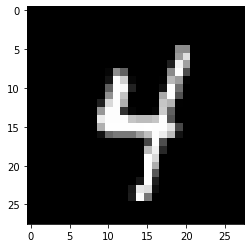

In [ ]:
index=np.random.randint(xtrain.shape[0], size=1)[0]
print(f"Image Label is: {ytrain[index]}")
plt.imshow(xtrain[index,:,:],cmap="gray");
plt.show();

## 2.2 Expanding the dataset

In [ ]:
x_train = xtrain.copy()
i = 0
for i in range(xtrain.shape[0]):
    x_train[i,:,:]=255-xtrain[i,:,:]

x_test = xtest.copy()
i=0
for i in range(xtest.shape[0]):
    x_test[i,:,:]=255-xtest[i,:,:]

x_train=np.concatenate((xtrain, x_train))
y_train=np.concatenate((ytrain, ytrain))
x_test=np.concatenate((xtest, x_test))
y_test=np.concatenate((ytest, ytest))

In [ ]:
print(f"New Training data size is {x_train.shape}\nNew Testing data size is {x_test.shape}")
print(f"New Training Label data size is {y_train.shape}\nNew Testing Label data size is {y_test.shape}")

New Training data size is (120000, 28, 28)
New Testing data size is (20000, 28, 28)
New Training Label data size is (120000,)
New Testing Label data size is (20000,)


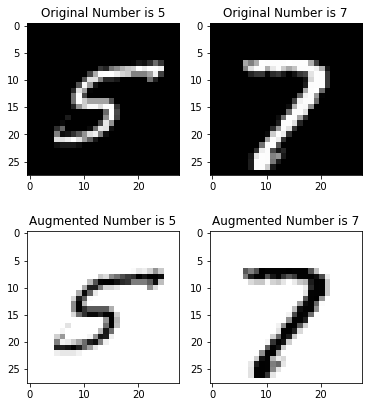

In [ ]:
x_train_vis = x_train.reshape(x_train.shape[0], 28, 28)

fig, axs = plt.subplots(2, 2, figsize=(6, 7))

for i in range(2):
  index=np.random.randint(xtrain.shape[0], size=1)[0]
  index_aug=index+xtrain.shape[0]

  axs[0,i].imshow(x_train_vis[index], cmap='gray')
  axs[0,i].set(title = f"Original Number is {y_train[index]}");
  
  axs[1,i].imshow(x_train_vis[index_aug], cmap='gray')
  axs[1,i].set(title = f"Augmented Number is {y_train[index_aug]}");

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [ ]:
x_train=x_train/255
x_test=x_test/255

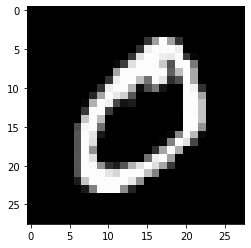

In [ ]:
plt.imshow(x_train[1,:,:],cmap="gray")
plt.show()

## 2.4 Reshape

Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
canal = 1 => For gray scale



In [ ]:
x_train=x_train.reshape(x_train.shape[0], 28, 28,1)
x_test=x_test.reshape(x_test.shape[0], 28, 28,1)
print(x_train.shape)
print(x_test.shape)

(120000, 28, 28, 1)
(20000, 28, 28, 1)


**Sample Data Visualization**

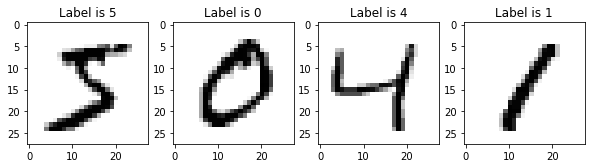

In [ ]:
x_train_vis = x_train.reshape(x_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(10, 5))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train_vis[i], cmap='binary')
    ax.set(title = f"Label is {y_train[i]}");

## 2.5 Label encoding

**One-Hot Encoding**
Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0

ytrain_enc=to_categorical(y_train)
ytest_enc=to_categorical(y_test)

In [ ]:
ytrain_enc.shape

(120000, 10)

## 2.6 Data augmentation

To avoid the overfitting problem, data
augmentation is used to expand the dataset to
alter the training data in ways that change the
array representation while keeping the label
the same. The aim is to apply small
transformations to the training data to
generate more data samples to reproduce the
variations occurring when the digit is written
by someone. For example, the digit is not
centered, the digit is rotated, and the scale is
not the same. Some popular augmentation
techniques are flips, random crops, rotations,
grayscale, color jitters, and translations. By
applying a couple of these transformations to
the training data, as shown in figure 8, it can
double or triple the number of training
examples and create a very powerful model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.98%
   - With data augmentation i achieved 99.65% of accuracy

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        ) 

train_gen = datagen.flow(x_train, ytrain_enc, batch_size=128)
test_gen = datagen.flow(x_test, ytest_enc, batch_size=128)

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
**I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.**

Once our model is ready, we fit the training dataset .

# 3. CNN

The model consists of five convolutional
layers followed by a fully connected, and
output layer. 
The first convolutional layer
uses ReLU activation function and has 32
neurons and a filter size (F) of 3×3. It gets the
input image of the size N×N=28×28 pixels
with 0 paddings (P) and a stride of 1 (S). the
output after the completion of the convolution
operation is feature maps of size (26×26, 32),
where 32 is the total feature maps equal to the
number of neurons used. The output size of
26×26.
The ReLU activation is applied to the output
of each feature map and then followed by
another convolutional layer with 64 neurons
which produces the output size (24×24, 64).
The first max-pooling layer is applied after
these two convolutional layers. This layer
receives the input as the output of the previous
layer with size (24×24, 64). It has a kernel or
pooling size of 2×2, with 0 paddings, and a
stride of 2. The output after the max-pooling
size is (12×12, 64) as the dimension is
reduced by 50% from 24×24 to 12×12 due to
the kernel size of 2 with a stride of 2. The
number of feature maps in the output has the
same features (64) as the previous
convolutional layer because max-pooling is
done in each feature map.
The first set of layers (convolutional and
pooling) is followed by batch normalization
and then connected to another set of
convolutional and pooling layers with the
same operation till it reaches the flattening
and fully connected layer. The flattening layer
gets the input from the previous layer with a
size of (1 × 1, 256) and produces a 1-D vector
of size 256 by flattening it, which is used as
input to the fully connected layer, which
outputs a 1-D vector of size 512.
The last layer of the model is the output layer.
It receives input as a 1-D vector with a size of
512 from the fully connected layer, and it
gives output as 1-D with a size of 10, which
represents the number of dataset classes (0 to
9). It uses a SoftMax activation function tocalculate the probability of each class
producing the final output

## 3.1 Define the model

**Model Definition**

In [ ]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

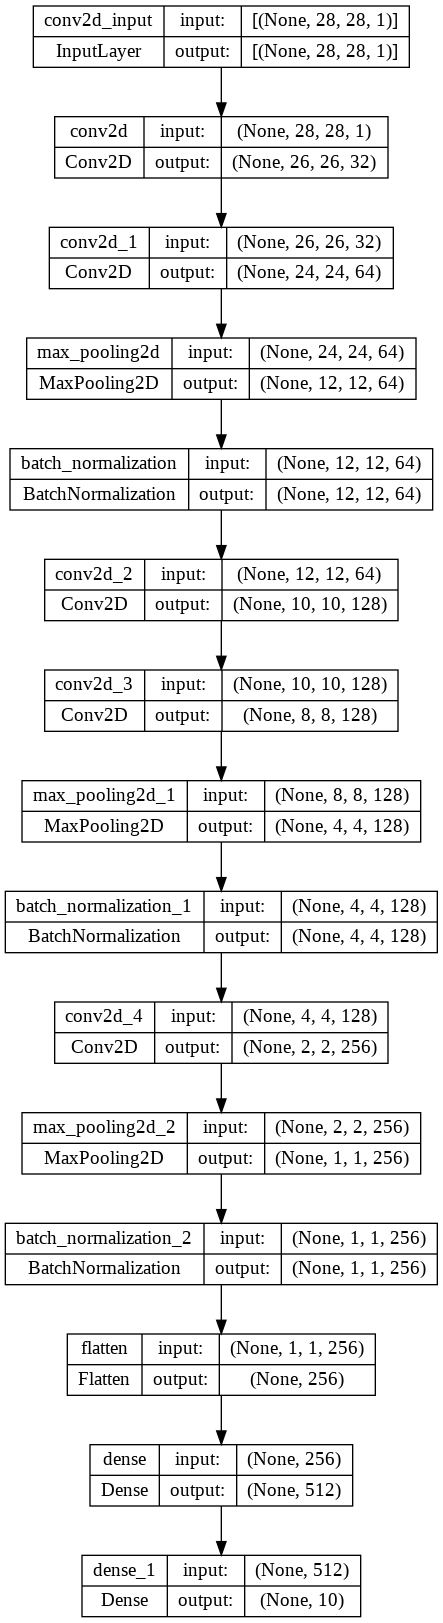

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

## 3.2 Model training

### Drive training phase
**EarlyStoping**: Stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.

In [ ]:
epochs = 50
batch_size = 128
train_steps = x_train.shape[0] // batch_size
valid_steps = x_test.shape[0] // batch_size

es = EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=5, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )
rp = ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
# Fit the model
model.fit(train_gen, 
          epochs = epochs, 
          steps_per_epoch = train_steps,
          validation_data = test_gen,
          validation_steps = valid_steps, 
          callbacks=[es, rp])

Epoch 1/50
937/937 [==============================] - 58s 50ms/step - loss: 0.1291 - accuracy: 0.9599 - val_loss: 0.0723 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 45s 48ms/step - loss: 0.0507 - accuracy: 0.9844 - val_loss: 0.0662 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 44s 47ms/step - loss: 0.0400 - accuracy: 0.9877 - val_loss: 0.0474 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 49s 53ms/step - loss: 0.0350 - accuracy: 0.9894 - val_loss: 0.0366 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 46s 49ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.0470 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 50s 53ms/step - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.0340 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 45s 

**Saving the model (Backup)**

(ensure to change the directory or create a folder in your google drive named "Saved_models")

In [ ]:
model.save('/content/gdrive/My Drive/Saved_Models/MNIST_final_model.h5')

**Reusing the default dataset for the base model training (Not Expanded or augmented)**

In [ ]:
xtrain=xtrain/255
xtest=xtest/255

xtrain=xtrain.reshape(xtrain.shape[0], 28, 28,1)
xtest=xtest.reshape(xtest.shape[0], 28, 28,1)

ytrain_encod=to_categorical(ytrain)
ytest_encod=to_categorical(ytest)

train_steps = xtrain.shape[0] // batch_size
valid_steps = xtest.shape[0] // batch_size

In [ ]:
modelB=Sequential()

modelB.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu", 
                  input_shape=(28,28,1)))
modelB.add(MaxPooling2D(pool_size=(2,2)))


modelB.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
modelB.add(MaxPooling2D(pool_size=(2,2)))


modelB.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
modelB.add(MaxPooling2D(pool_size=(2,2)))

modelB.add(Flatten())
modelB.add(Dense(256,activation="relu"))
modelB.add(Dense(10,activation="softmax"))
    
modelB.compile(loss="categorical_crossentropy", optimizer="adam", 
               metrics=["accuracy"])

In [ ]:
# Fit the model
modelB.fit(xtrain,
           ytrain_encod,
           epochs = epochs, 
           steps_per_epoch = train_steps,
           validation_data=(xtest,ytest_encod),
           validation_steps = valid_steps, 
           callbacks=[es, rp])

Epoch 1/50
468/468 [==============================] - 4s 7ms/step - loss: 0.3074 - accuracy: 0.9077 - val_loss: 0.1177 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 2/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0922 - accuracy: 0.9718 - val_loss: 0.1034 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 3/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0661 - accuracy: 0.9800 - val_loss: 0.0608 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 4/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0531 - accuracy: 0.9832 - val_loss: 0.0495 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 5/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.0624 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 6/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0509 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 7/50
468/468 [==============================] - 3s 6ms/step - lo

**Saving the model (Backup)**

In [ ]:
modelB.save('/content/gdrive/My Drive/Saved_Models/MNIST_base_model.h5')

# 4. Evaluate the model

## 4.1 Training and validation curves

In [ ]:
final_model_metrics = model.history.history
base_model_metrics = modelB.history.history

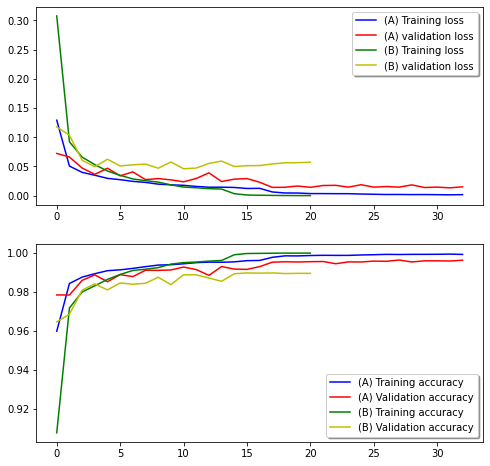

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(8, 8))
ax[0].plot(final_model_metrics['loss'], color='b', label="(A) Training loss")
ax[0].plot(final_model_metrics['val_loss'], color='r', label="(A) validation loss")

ax[0].plot(base_model_metrics['loss'], color='g', label="(B) Training loss")
ax[0].plot(base_model_metrics['val_loss'], color='y', label="(B) validation loss")

legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(final_model_metrics['accuracy'], color='b', label="(A) Training accuracy")
ax[1].plot(final_model_metrics['val_accuracy'], color='r',label="(A) Validation accuracy")

ax[1].plot(base_model_metrics['accuracy'], color='g', label="(B) Training accuracy")
ax[1].plot(base_model_metrics['val_accuracy'], color='y',label="(B) Validation accuracy")

legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Classification Report

**Loading the model from backup**

In [ ]:
from tensorflow.keras.models import load_model
final_model=load_model('/content/gdrive/My Drive/Saved_Models/MNIST_final_model.h5')
base_model=load_model('/content/gdrive/My Drive/Saved_Models/MNIST_base_model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report 

In [ ]:
y_pred=final_model.predict(x_test) 
y_pred=np.argmax(y_pred,axis=1)
accuracy_score(y_test,y_pred)

625/625 [==============================] - 2s 2ms/step


0.9965

In [ ]:
y_predB=base_model.predict(xtest) 
y_predB=np.argmax(y_predB,axis=1)
accuracy_score(ytest,y_predB)

313/313 [==============================] - 1s 2ms/step


0.9898

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1960
           1       1.00      1.00      1.00      2270
           2       1.00      1.00      1.00      2064
           3       0.99      1.00      1.00      2020
           4       1.00      1.00      1.00      1964
           5       1.00      0.99      1.00      1784
           6       1.00      1.00      1.00      1916
           7       1.00      0.99      1.00      2056
           8       1.00      1.00      1.00      1948
           9       1.00      0.99      1.00      2018

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
print(classification_report(ytest,y_predB))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## 4.3 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

313/313 [==============================] - 1s 3ms/step


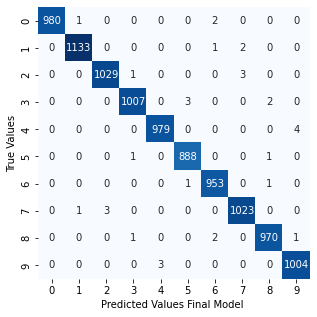

In [ ]:
fig = plt.figure(figsize=(5, 5))

y_pred = final_model.predict(xtest) 
Y_pred = np.argmax(y_pred, 1)

mat = confusion_matrix(ytest, Y_pred) 

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, 
            annot=True, cbar=False, 
            cmap=plt.cm.Blues, fmt='.0f')

plt.xlabel('Predicted Values Final Model ')
plt.ylabel('True Values');
plt.show();

313/313 [==============================] - 1s 2ms/step


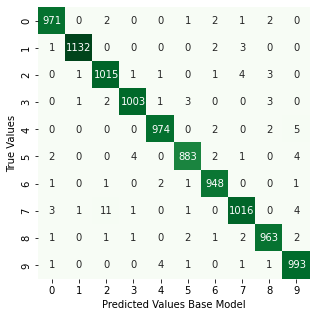

In [ ]:
fig = plt.figure(figsize=(5, 5)) # Set Figure

y_predB = base_model.predict(xtest) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]
Y_predB = np.argmax(y_predB, 1) # Decode Predicted labels

matB = confusion_matrix(ytest, Y_predB) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(matB.T, square=True, annot=True, cbar=False, cmap=plt.cm.Greens, fmt='.0f')
plt.xlabel('Predicted Values Base Model')
plt.ylabel('True Values');
plt.show();

# 5. Prediction

## 5.1 Prediction validation results

625/625 [==============================] - 1s 2ms/step


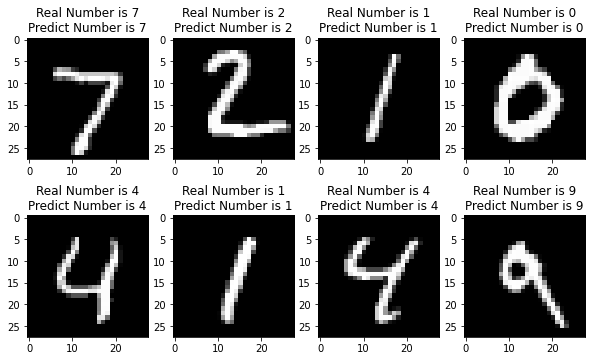

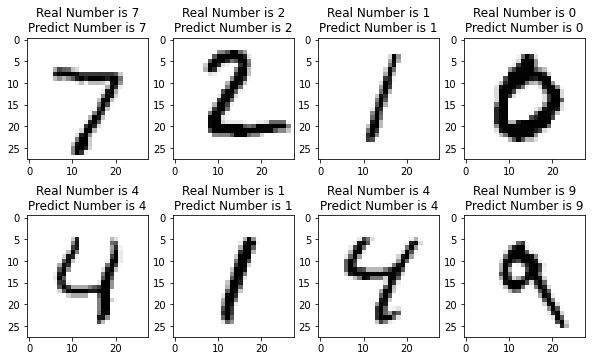

In [ ]:
y_pred = final_model.predict(x_test)
X_test__ = x_test.reshape(x_test.shape[0], 28, 28)

fig, axis = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='gray')
    ax.set(title = f"Real Number is {ytest_enc[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

fig, axis = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i+10000], cmap='gray')
    ax.set(title = f"Real Number is {ytest_enc[i+10000].argmax()}\nPredict Number is {y_pred[i+10000].argmax()}");

313/313 [==============================] - 1s 2ms/step


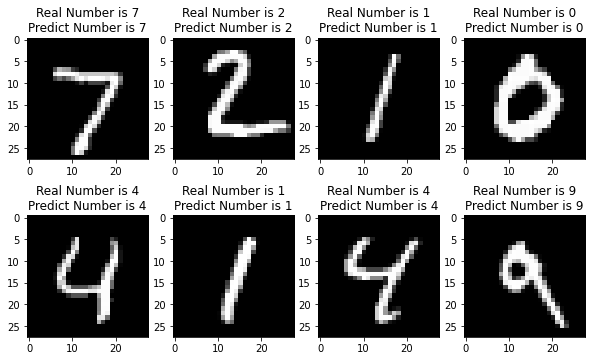

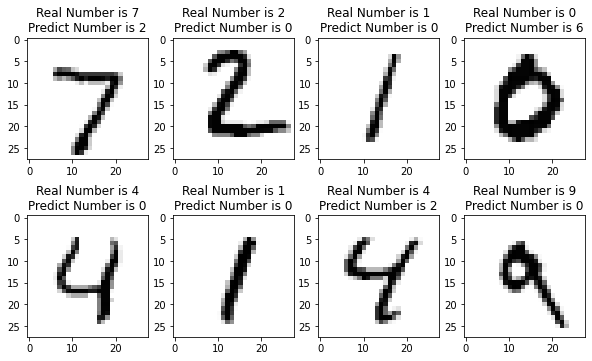

In [ ]:
y_predB = base_model.predict(xtest)
X_test__ = xtest.reshape(xtest.shape[0], 28, 28)

fig, axis = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='gray')
    ax.set(title = f"Real Number is {ytest_encod[i].argmax()}\nPredict Number is {y_predB[i].argmax()}");

augm_xtest = xtest.copy()
i=0
for i in range(xtest.shape[0]):
    augm_xtest[i,:,:]=1-xtest[i,:,:]

y_predB = base_model.predict(augm_xtest)
X_test__ = augm_xtest.reshape(augm_xtest.shape[0], 28, 28)

fig, axis = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='gray')
    ax.set(title = f"Real Number is {ytest_encod[i].argmax()}\nPredict Number is {y_predB[i].argmax()}");

## 5.2 Prediction using external images from google drive

Prediction is done using a handwritten image with some noise 

*   captured by phone camera
*   with axis and small numbers on it
*   with different sizes and different colormap

In [ ]:
img_9 = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/9.png')
img_9 = cv2.cvtColor(img_9,cv2.COLOR_BGR2GRAY)
img9 = cv2.resize(img_9, (28,28))
img9 = img9.reshape(1, 28, 28,1)
img9_nor = img9/255

img_5 =cv2.imread('/content/gdrive/My Drive/Colab Notebooks/5.png')
img_5 =cv2.cvtColor(img_5,cv2.COLOR_BGR2GRAY)
img5 = cv2.resize(img_5, (28,28))
img5 = img5.reshape(1, 28, 28,1)
img5_nor = img5/255

1/1 [==============================] - 0s 17ms/step


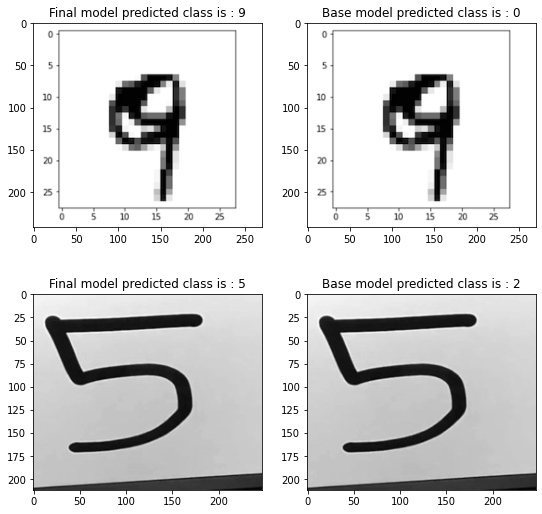

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[0,0].imshow(img_9, cmap='gray')
axs[0,0].set(title = f"Final model predicted class is : 
                        {np.argmax(final_model.predict(img9_nor))}");
axs[0,1].imshow(img_9, cmap='gray')
axs[0,1].set(title = f"Base model predicted class is : 
                        {np.argmax(base_model.predict(img9_nor))}");

axs[1,0].imshow(img_5, cmap='gray')
axs[1,0].set(title = f"Final model predicted class is : 
                        {np.argmax(final_model.predict(img5_nor))}");
axs[1,1].imshow(img_5, cmap='gray')
axs[1,1].set(title = f"Base model predicted class is : 
                          {np.argmax(base_model.predict(img5_nor))}");